<div class="alert-info alert">
    <h1>Complex patterns in a simple system</h1>
</div>

## Imports

In [1]:
%pip install ngsolve
import numpy as np
import matplotlib.pyplot as plt
from netgen.meshing import Mesh as NGMesh 
from netgen.geom2d import unit_square 
from ngsolve import *


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


## Gray-Scott-Equation

Using testfunctions (w, q) to verify weak formulation

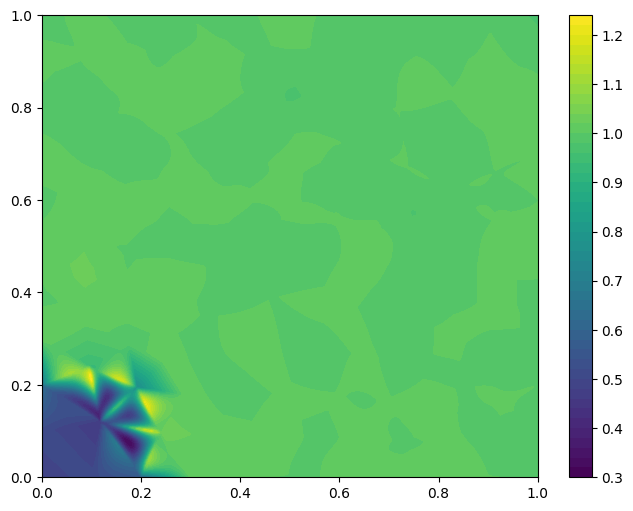

In [3]:
# Parameters
eps1 = Parameter(2e-5)
eps2 = Parameter(1e-5)
F = Parameter(0.048)
k = Parameter(0.065)
dt = 0.01

# FEM space definition
m = NGMesh(dim=1)
mesh = Mesh(unit_square.GenerateMesh(maxh=0.1))
order = 3
V = Periodic(H1(mesh,order=order))
X = V*V
(u, v) = X.TrialFunction()
(w, q) = X.TestFunction() 

# Bilinearform
a = BilinearForm(X,symmetric=True)
a += (u / dt) * w * dx + eps1 * grad(u) * grad(w) * dx
a += (v / dt) * q * dx + eps2 * grad(v) * grad(q) * dx
a.Assemble() 



"""print(a.mat) # Matrix saves != 0 
print(m.mat)"""

"""a = BilinearForm(X , symmetric=True)
a += (u / dt) * w * dx + eps1 * grad(u) * grad(w) * dx
a += (v / dt) * q * dx + eps2 * grad(v) * grad(q) * dx

gfuold = GridFunction(X)
gfvold = GridFunction(X)"""

l_dom = 1.5 # Laenge des Quadrats
n_dom = 75 # Anzahl Elemente pro Kante

gfx = GridFunction(X)
gfu, gfv = gfx.components

gfxold = GridFunction(X)
gfuold, gfvold = gfxold.components

l_init = l_dom/n_dom*20
gfuold.Set(IfPos((l_init/2)**2-x*x,
                 IfPos((l_init/2)**2-y*y,0.5,1),1))
gfvold.Set(IfPos((l_init/2)**2-x*x,
                 IfPos((l_init/2)**2-y*y,0.25,0),0))
gfxold.vec[:] += 0.01*np.random.normal(size=X.ndof)
gfx.vec.data = gfxold.vec

# Linearform
f = LinearForm(X)
f += dt * (-gfuold * gfvold**2 + F * (1 - gfuold)) * w * dx(bonus_intorder=4)
f += dt * (gfuold * gfvold**2 - (k + F) * gfvold) * q * dx(bonus_intorder=4)
f.Assemble()

"""b = LinearForm(X)
#b += (-gfuold * gfvold**2 + F * (1 - gfuold)) * w1 * dx
#b += (gfuold * gfvold**2 - (k + F) * gfvold) * w2 * dx
b += (-gfuold.components[0] * gfvold.components[1]**2 + F * (1 - gfuold.components[0])) * w1 * dx
b += (gfuold.components[0] * gfvold.components[1]**2 - (k + F) * gfvold.components[1]) * w2 * dx"""

gfx = GridFunction(X)
gfx.vec.data = a.mat.Inverse(freedofs=X.FreeDofs()) * f.vec
 
 
x_vals = np.linspace(0, 1, 400)
y_vals = np.linspace(0, 1, 400)
solution = np.zeros((400, 400))

for i, x in enumerate(x_vals):
    for j, y in enumerate(y_vals):
        solution[j, i] = gfu(mesh(x, y))

X, Y = np.meshgrid(x_vals, y_vals)
fig, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(X, Y, solution, levels=50, cmap="viridis")
fig.colorbar(contour)
plt.show()

# TODO: Verfikation



## Time dependent system

In [ ]:
from ngsolve import *
import numpy as np
import matplotlib.pyplot as plt
#import netgen.gui 
from ngsolve.webgui import Draw
from netgen.occ import OCCGeometry, Rectangle, MoveTo, Glue, X as Xocc, Y as Yocc

# Parameter
eps1 = Parameter(2e-5)
eps2 = Parameter(1e-5)
dt = 2
num_time_steps = 4000
"""(0.04, 0.02),
    (0.03, 0.06),
    (0.05, 0.065),
    (0.06, 0.06),
    (0.06, 0.05),
    (0.03, 0.03),
    (0.01, 0.02),
    (0.04, 0.06),
    (0.01, 0.07),
    (0.06, 0.0625),
    (0.037, 0.06),
    (0.038, 0.06),
    (0.04, 0.05),
    (0.024, 0.054),
    (0.055, 0.065),
    (0.015, 0.045)"""
parameter_saetze = [  # (F, k)
    (0.015,0.045)
]

# Zeitintegration und Visualisierung
for F_value, k_value in parameter_saetze:
    l_dom = 1.5 # Laenge des Quadrats
    n_dom = 175 # Anzahl Elemente pro Kante
    rec = MoveTo(-l_dom/2,-l_dom/2).Rectangle(l_dom,l_dom).Face()

    rec.edges.Max(Xocc).name = 'right'
    rec.edges.Min(Xocc).name = 'left'
    rec.edges.Max(Yocc).name = 'top'
    rec.edges.Min(Yocc).name = 'bottom'

    right=rec.edges.Max(Xocc)
    rec.edges.Min(Xocc).Identify(right,name="left")

    top=rec.edges.Max(Yocc)
    rec.edges.Min(Yocc).Identify(top,name="bottom")

    geo = OCCGeometry(rec,dim=2)

    mesh = Mesh(geo.GenerateMesh(maxh=l_dom / n_dom))

    order = 3
    V = Periodic(H1(mesh, order=order))
    X = V * V
    (u, v) = X.TrialFunction()
    (w, q) = X.TestFunction()

    gfx = GridFunction(X)
    gfu, gfv = gfx.components
    gfxold = GridFunction(X)
    gfuold, gfvold = gfxold.components

    l_init = l_dom / n_dom * 20
    gfuold.Set(IfPos((l_init/2)**2-x*x,
                    IfPos((l_init/2)**2-y*y,0.5,1),1))
    gfvold.Set(IfPos((l_init/2)**2-x*x,
                    IfPos((l_init/2)**2-y*y,0.25,0),0))
    gfxold.vec[:] += 0.01*np.random.normal(size=X.ndof)
    gfx.vec.data = gfxold.vec


    # Bilinearform A (Diffusionsteil)
    """a = BilinearForm(X, symmetric=True)
    a += (u / dt) * w * dx + eps1 * grad(u) * grad(w) * dx
    a += (v / dt) * q * dx + eps2 * grad(v) * grad(q) * dx
    a.Assemble()"""
    a = BilinearForm(X, symmetric=True)
    a += eps1 * grad(u) * grad(w) * dx  
    a += eps2 * grad(v) * grad(q) * dx  
    a.Assemble()

    # Bilinearform (Massenmatrix M)
    m = BilinearForm(X, symmetric=True)
    m += u * w * dx
    m += v * q * dx
    m.Assemble()
    mstar = m.mat.CreateMatrix()
    mstar.AsVector().data = m.mat.AsVector() + dt * a.mat.AsVector()
    mstarinv = mstar.Inverse(freedofs=X.FreeDofs(), inverse="sparsecholesky")

    F = Parameter(F_value)
    k = Parameter(k_value)

    # Linearform f
    f = LinearForm(X)
    f += dt * (-gfuold * gfvold**2 + F * (1 - gfuold)) * w * dx(bonus_intorder=4)
    f += dt * (gfuold * gfvold**2 - (k + F) * gfvold) * q * dx(bonus_intorder=4)

    scene_u = Draw(gfu)
    scene_v = Draw(gfv)

    print(f"(i) F={F_value}, k={k_value} starting...")

    res = gfx.vec.CreateVector()
    deltauv = gfx.vec.CreateVector()

    with TaskManager():
        for step in range(num_time_steps):
            f.Assemble()

            # RHS = -dtA(u,v) + dtf(u,v) 
            """res.data = - dt * a.mat * gfxold.vec + dt * f.vec
            # (du, dv) = M^(*)^-1 * res
            deltauv.data = mstarinv * res"""

            res.data = - dt * a.mat * gfxold.vec + dt * f.vec

            deltauv.data = mstarinv * res 
            gfx.vec.data += deltauv.data
            gfxold.vec.data = gfx.vec.data
            
            deltauvNorm = deltauv.Norm()

            if step % 10 == 0:
                scene_u.Redraw()
                scene_v.Redraw()

            print(f"Timestep: {step}, Norm: {deltauvNorm}", end="\r")

            if deltauvNorm < 1e-8:
                break

        Npixel = 800
        xi = np.linspace(-l_dom / 2, l_dom / 2, Npixel)
        Xi, Yi = np.meshgrid(xi, xi)
        mips = mesh(Xi.flatten(), Yi.flatten())

        ui = gfu(mips).reshape((Npixel, Npixel))
        vi = gfv(mips).reshape((Npixel, Npixel))

        plt.figure(figsize=(5, 5))
        plt.imshow(ui > 0.5, cmap="gray_r")
        plt.axis("off")
        plt.tight_layout()
        plt.savefig(f"reaction_diffusion_F{F_value}_k{k_value}_dt{dt}_steps{num_time_steps}_u.pdf")
        plt.show()

        plt.figure(figsize=(5, 5))
        plt.imshow(vi, cmap="gray_r")
        plt.axis("off")
        plt.tight_layout()
        plt.savefig(f"reaction_diffusion_F{F_value}_k{k_value}_dt{dt}_steps{num_time_steps}_v.pdf")
        plt.show()


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

(i) F=0.015, k=0.045 starting...


In [3]:
##### from ngsolve import *
import numpy as np
import matplotlib.pyplot as plt
#import netgen.gui 
from ngsolve.webgui import Draw
from netgen.occ import OCCGeometry, Rectangle, MoveTo, Glue, X as Xocc, Y as Yocc
# TRAPEZMETHODE
# Parameter
eps1 = Parameter(2e-5)
eps2 = Parameter(1e-5)
dt = 2
num_time_steps = 4000
"""(0.04, 0.02),
    (0.03, 0.06),
    (0.05, 0.065),
    (0.06, 0.06),
    (0.06, 0.05),
    (0.03, 0.03),
    (0.01, 0.02),
    (0.04, 0.06),
    (0.01, 0.07),
    (0.06, 0.0625),
    (0.037, 0.06),
    (0.038, 0.06),"""
parameter_saetze = [  # (F, k)
    
    
    (0.06, 0.0625),
]

# Zeitintegration und Visualisierung
for F_value, k_value in parameter_saetze:
    l_dom = 1.5 # Laenge des Quadrats
    n_dom = 75 # Anzahl Elemente pro Kante
    rec = MoveTo(-l_dom/2,-l_dom/2).Rectangle(l_dom,l_dom).Face()

    rec.edges.Max(Xocc).name = 'right'
    rec.edges.Min(Xocc).name = 'left'
    rec.edges.Max(Yocc).name = 'top'
    rec.edges.Min(Yocc).name = 'bottom'

    right=rec.edges.Max(Xocc)
    rec.edges.Min(Xocc).Identify(right,name="left")

    top=rec.edges.Max(Yocc)
    rec.edges.Min(Yocc).Identify(top,name="bottom")

    geo = OCCGeometry(rec,dim=2)

    mesh = Mesh(geo.GenerateMesh(maxh=l_dom / n_dom))

    order = 3
    V = Periodic(H1(mesh, order=order))
    X = V * V
    (u, v) = X.TrialFunction()
    (w, q) = X.TestFunction()

    gfx = GridFunction(X)
    gfu, gfv = gfx.components
    gfxold = GridFunction(X)
    gfuold, gfvold = gfxold.components

    l_init = l_dom / n_dom * 20
    gfuold.Set(IfPos((l_init/2)**2-x*x,
                    IfPos((l_init/2)**2-y*y,0.5,1),1))
    gfvold.Set(IfPos((l_init/2)**2-x*x,
                    IfPos((l_init/2)**2-y*y,0.25,0),0))
    gfxold.vec[:] += 0.01*np.random.normal(size=X.ndof)
    gfx.vec.data = gfxold.vec


    # Bilinearform A (Diffusionsteil)
    """a = BilinearForm(X, symmetric=True)
    a += (u / dt) * w * dx + eps1 * grad(u) * grad(w) * dx
    a += (v / dt) * q * dx + eps2 * grad(v) * grad(q) * dx
    a.Assemble()"""
    a = BilinearForm(X, symmetric=True)
    a += eps1 * grad(u) * grad(w) * dx  
    a += eps2 * grad(v) * grad(q) * dx  
    a.Assemble()

    # Bilinearform (Massenmatrix M)
    m = BilinearForm(X, symmetric=True)
    m += u * w * dx
    m += v * q * dx
    m.Assemble()
    print(m)
    mstar = m.mat.CreateMatrix()
    mstar.AsVector().data = m.mat.AsVector() + dt * a.mat.AsVector()
    mstarinv = mstar.Inverse(freedofs=X.FreeDofs(), inverse="sparsecholesky")

    F = Parameter(F_value)
    k = Parameter(k_value)

    # Linearform f
    f = LinearForm(X)
    f += dt * (-gfuold * gfvold**2 + F * (1 - gfuold)) * w * dx(bonus_intorder=4)
    f += dt * (gfuold * gfvold**2 - (k + F) * gfvold) * q * dx(bonus_intorder=4)

    f_new = LinearForm(X)
    f_new += dt * (-gfu * gfv**2 + F * (1 - gfu)) * w * dx(bonus_intorder=4)
    f_new += dt * (gfu * gfv**2 - (k + F) * gfv) * q * dx(bonus_intorder=4)

    scene_u = Draw(gfu)
    scene_v = Draw(gfv)

    print(f"(i) F={F_value}, k={k_value} starting (trapez)...")

    res = gfx.vec.CreateVector()
    deltauv = gfx.vec.CreateVector()

    with TaskManager():
        for step in range(num_time_steps):
            f.Assemble()
            f_new.Assemble()

            A_avg = 0.5 * (a.mat * gfx.vec + a.mat * gfxold.vec) 
            f_avg = 0.5 * (f_new.vec  + f.vec)
            res.data = dt * f_avg - dt * A_avg 
            deltauv.data = mstarinv * res 
            
            gfxold.vec.data = gfx.vec.data
            gfx.vec.data += deltauv.data
            deltauvNorm = deltauv.Norm()

            if step % 10 == 0:
                scene_u.Redraw()
                scene_v.Redraw()

            print(f"Timestep: {step}, Norm: {deltauvNorm}", end="\r")

            if deltauvNorm < 1e-8:
                break

        Npixel = 800
        xi = np.linspace(-l_dom / 2, l_dom / 2, Npixel)
        Xi, Yi = np.meshgrid(xi, xi)
        mips = mesh(Xi.flatten(), Yi.flatten())

        ui = gfu(mips).reshape((Npixel, Npixel))
        vi = gfv(mips).reshape((Npixel, Npixel))
        plt.figure(figsize=(5, 5))
        plt.imshow(vi, cmap="gray_r")
        plt.axis("off")
        plt.tight_layout()
        plt.show()
        plt.figure(figsize=(5, 5))
        plt.imshow(ui > 0.5, cmap="gray_r")
        plt.axis("off")
        plt.tight_layout()
        plt.show()

       


on space CompoundFESpaces
symmetric   = 1
multilevel  = 1
nonassemble = 0
printelmat = 0
elmatev    = 0
eliminate_internal = 0
eliminate_hidden = 0
keep_internal = 0
store_inner = 0
integrators: 
  Symbolic BFI
  Symbolic BFI



WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

(i) F=0.06, k=0.0625 starting (trapez)...


KeyboardInterrupt: 